# Switching dynamics

In the case of the switching dynamics we assume that the reward probability $p_{t}$ changes suddenly but is otherwise constant. We can express the dynamics of reward probabilities as 
\begin{equation}
    p_{t} \sim \left\{ \begin{array}{cc}
        Beta(1, 1) & \textrm{for } j_{t-1} = 1  \\
        \delta(p_{t} - p_{t-1}) & \textrm{for } j_{t-1} = 0
    \end{array}
    \right.
\end{equation}
where $Beta(1, 1)$ denotes beta (uniform) distribution, and $\delta(x)$ Dirac's delta function. Similarly, we will express the transition probability of the change point variable $j_{t}$ as
\begin{equation}
    p(j_{t}=j|j_{t-1}) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1} = 1  \\
        \rho^{j}(1-\rho)^{1-j} & \textrm{for } j_{t-1} = 0
    \end{array}
    \right.
\end{equation}
where $\delta_{j,0} = 1$ for $j=0$.

Let us first implement the generative process of the switching bandits.

In [2]:
import numpyro as npyro
import numpyro.distributions as dist

import jax.numpy as np
from jax import random, lax, nn, ops

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
K = 10
rho = .01

log_p_jj = np.log(np.array([[1 - rho, rho], [1, 0]]))

def process(t, choices, states, rng_key):
    probs, changes = states
    
    rng_key, _rng_key = random.split(rng_key)
    new_changes = random.categorical(_rng_key, log_p_jj[changes])
    
    rng_key, _rng_key = random.split(rng_key)
    random_probs = random.uniform(_rng_key, shape=(K,))
    
    new_probs = np.where(new_changes, random_probs, probs)
   
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs)
    
    return outcomes[choices], [new_probs, new_changes]

def simulator(process, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, states = process(t, choices, states, _rng_key)
        
        return (rng_key, states, choices), {'rewards': outcomes, 'probs': states[0], 'changes': states[1]}
    
    rng_key = random.PRNGKey(4483342)
    states = [random.uniform(rng_key, shape=(K,)), np.zeros(K, dtype=np.int32)]
    choices = np.zeros(N, dtype=np.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, choices), np.arange(T))
    
    sequence['probs'] = np.concatenate([states[0][None], sequence['probs']], 0)[:-1]
    sequence['changes'] = np.concatenate([states[1][None], sequence['changes']], 0)[:-1]
    
    return sequence

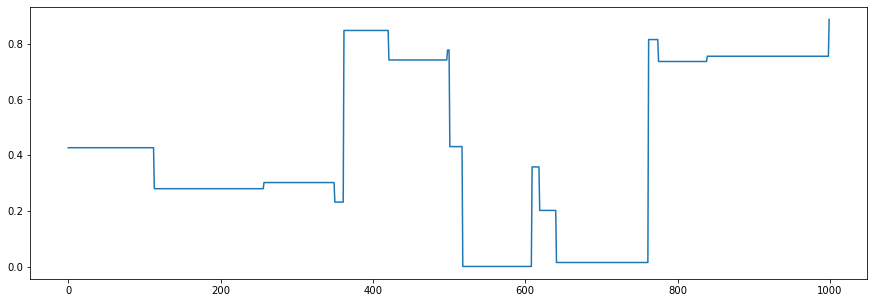

In [4]:
sequence = simulator(process)

plt.subplots(figsize=(15, 5))
plt.plot(sequence['probs'][:, 0])

obs_swtch = sequence['rewards'][:, 0]
probs_swtch = sequence['probs'][:, 0]

# Drifting dynamics

In the case of the driftingdynamics we assume that the reward probability $p_{t}$ continiously following a random walk. We can express the dynamics of reward probabilities as 
\begin{equation}
    \textrm{logit}(p_{t}) = \textrm{logit}(p_{t-1}) + \sqrt{\sigma} \cdot n_t 
\end{equation}
where $n_t \sim \mathcal{N}(0, 1)$ and $p_0 \sim U(0, 1)$. We will consider $\sigma=0.01$

In [5]:
from jax.scipy.special import logit, expit

sigma = .01
def process(t, choices, states, rng_key):
    probs, _ = states
    
    rng_key, _rng_key = random.split(rng_key)
    x =  logit(probs) + np.sqrt(sigma) * random.normal(_rng_key, shape=(K,))
    
    rng_key, _rng_key = random.split(rng_key)
    outcomes = random.bernoulli(_rng_key, probs)
    
    return outcomes[choices], [expit(x), np.zeros(K, dtype=np.int32)]

def simulator(process, N=100, T=1000):
    def sim_fn(carry, t):
        rng_key, states, choices = carry
        rng_key, _rng_key = random.split(rng_key)
        
        outcomes, states = process(t, choices, states, _rng_key)
        
        return (rng_key, states, choices), {'rewards': outcomes, 'probs': states[0], 'changes': states[1]}
    
    rng_key = random.PRNGKey(4483342)
    states = [random.uniform(rng_key, shape=(K,)), np.zeros(K, dtype=np.int32)]
    choices = np.zeros(N, dtype=np.int32)
    
    _, sequence = lax.scan(sim_fn, (rng_key, states, choices), np.arange(T))
    
    sequence['probs'] = np.concatenate([states[0][None], sequence['probs']], 0)[:-1]
    sequence['changes'] = np.concatenate([states[1][None], sequence['changes']], 0)[:-1]
    
    return sequence

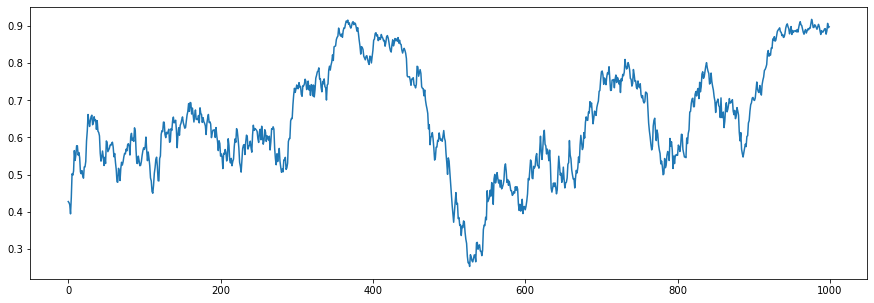

In [6]:
sequence = simulator(process)

plt.subplots(figsize=(15, 5))
plt.plot(sequence['probs'][:, 0])

obs_drft = sequence['rewards'][:, 0]
probs_drft = sequence['probs'][:, 0]

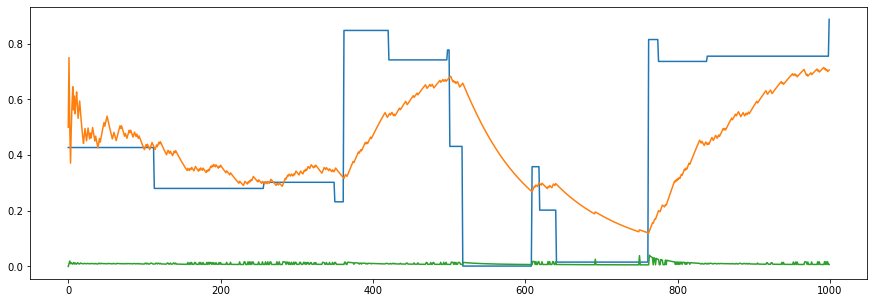

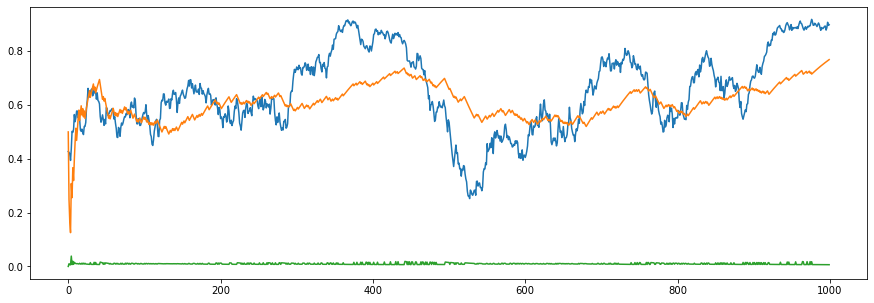

In [7]:
def learning(outcomes):
    a = [.5]
    b = [.5]
    
    m = [.5]
    e = [0.]
    for o in outcomes:
        pred = rho * (1 - e[-1])
        post = .5 * pred / (.5 * pred + m[-1]**o * (1-m[-1])**(1-o) * (1 - pred))
        a.append(a[-1] * ( 1 - post) + post * a[0] + o)
        b.append(b[-1] * (1 - post) + post * b[0] + (1 - o))
        m.append(a[-1]/(a[-1] + b[-1]))
        e.append(post)
        
    return m, e

m, e = learning(obs_swtch)

plt.subplots(figsize=(15, 5))
plt.plot(probs_swtch)
plt.plot(m[:-1])
plt.plot(e[:-1])

m, e = learning(obs_drft)

plt.subplots(figsize=(15, 5))
plt.plot(probs_drft)
plt.plot(m[:-1])
plt.plot(e[:-1])

Although it seems like the above variational algorithm does a fairly good job, it turns out that it is very slow in adjusting to changes as it underestimates uncertainty. One can see this using the following alghoritm that approximate likelihood with a set of descrete points, and implements an exact filtering algorithm.

Lets assume that reward probability can have only discrete value, for example 

$$ p \in P = \left\{\frac{1}{2D}, \ldots, 1-1/D\right\}$$

where $D$ denotes number of discrete values and $|P| = D$.

Hence if we associate different possible values with descrete hidden states $k_t$ we can describe the whole problem as a hierarchical hidden markov model. In this case the state transition matrix is given as 

$$ p(k_t|k_{t-1}, j_{t-1}=0) = I_D$$

that is, states do not change in the absence of a change point, and

$$ p(k_t|k_{t-1}, j_{t-1}=1) = \frac{1}{D-1} \left( J_{D} - I_D \right) $$

where $J_D$ stands for a D-dimensional matrix of ones, and $I_D$ for a D-dimensional identity matrix.

This way one can define an exact update of beliefs using Bayes rule

$$ p(k_t, j_t|o_{1:t}) \propto p(o_t|k_t)p(k_t,j_t|o_{1:t-1})$$

where 

$$ p(o_t|k_t=k) = p_k^{o_t}(1-p_k)^{1-o_t}$$

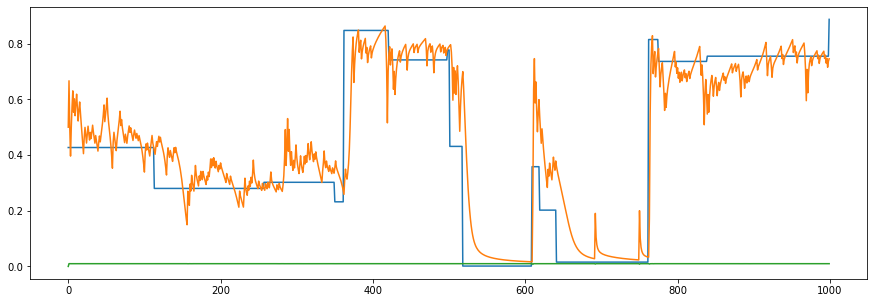

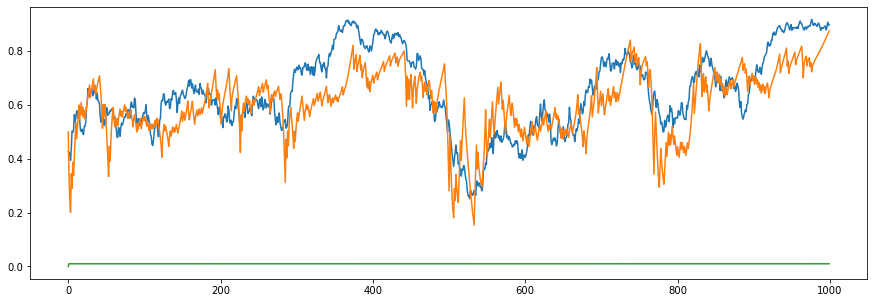

In [8]:
D = 100
p_jj = np.exp(log_p_jj)
p_jss = np.stack([np.eye(D), (np.ones((D,D)) - np.eye(D))/(D-1)], 0)

def learning(outcomes, D=10):
    likelihoods = np.arange(1/(2*D), 1., 1/D)[:, None]
    
    def scan_fn(probs, o):
        pred = np.einsum('ijk,il,ji->kl', p_jss, p_jj, probs)
        ol = likelihoods**o * (1 - likelihoods)**(1 - o)
        post = ol * pred
        
        m = np.sum(probs * likelihoods)
        e = probs.sum(-2)[-1]
        
        q = post/post.sum()
        return q, (m, e, q)

    probs = np.ones((D, 1))/D * np.array([1., 0])
    _, sequence = lax.scan(scan_fn, probs, outcomes)
        
    return sequence[0], sequence[1], sequence[-1]

m, e, post = learning(obs_swtch, D=D)

plt.subplots(figsize=(15, 5))
plt.plot(probs_swtch)
plt.plot(m)
plt.plot(e)

m, e, post = learning(obs_drft, D=D)

plt.subplots(figsize=(15, 5))
plt.plot(probs_drft)
plt.plot(m)
plt.plot(e)

Interestingly, although we consider only switching dynamics in the generative model, we get a fairly good estimates of the underlying probabilities in the drifting environment.

Above we have assumed that the agent already knows the change point probability, however in general this will be a hidden quantity for the agent. Here we will add another to the hierarchical HMM which corresponds to the  the change point probability also. Similar to likelihoods we can discretise the change point probability $\rho$ and assume that 

$$ \rho \in R = \left\{ \frac{1}{2M}, \ldots, 1-\frac{1}{M} \right\}, \qquad |R| = M$$

We will associate different possible values with descrete hidden states $r_t$, and express the change point transition matrix as 

\begin{equation}
    p(j_{t}=j|j_{t-1}, r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{j, 0} & \textrm{for } j_{t-1,l} = 1  \\
        \rho_r^{j}(1-\rho_r)^{1-j} & \textrm{for } j_{t-1,l} = 0
    \end{array}
    \right.
\end{equation}

and the $r_t$ transition probabability as a 1D random walk

\begin{equation}
    p(r_t=q|r_{t-1}=r) = \left\{ \begin{array}{cc}
        \delta_{q, r} & \textrm{with pr. } 1 - \kappa  \\
        \delta_{q, r + 1} & \textrm{with pr. } \kappa/2 \\
        \delta_{q, r - 1} & \textrm{with pr. } \kappa/2
    \end{array}
    \right.
\end{equation}

The belief update becomes

$$ p(k_t, j_t, r_t|o_{1:t}) \propto p(o_t|k_t)p(k_t,j_t, r_t|o_{1:t-1})$$

where we will assume a priory a bias toward small change probabilities, hence 

$$ p(r_0 = r) \propto e^{-\lambda r} $$

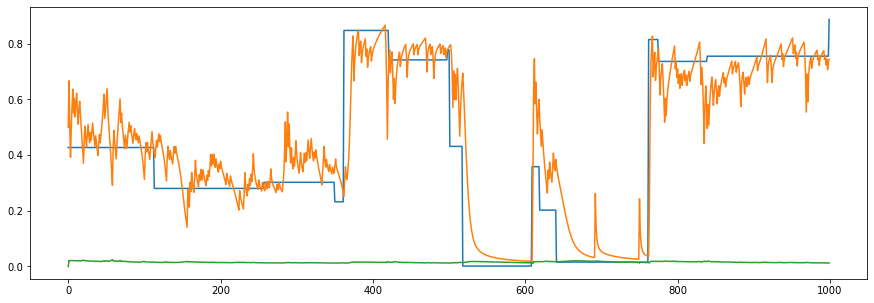

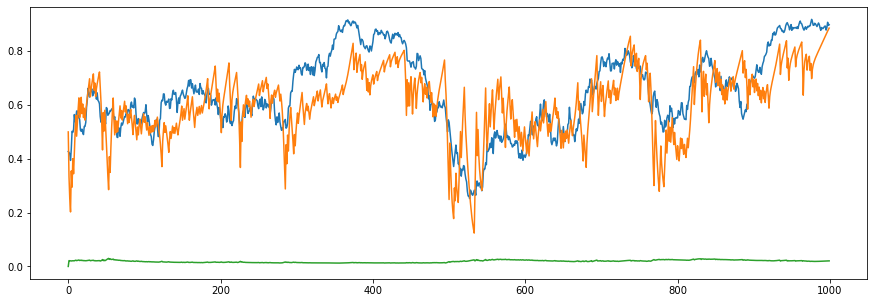

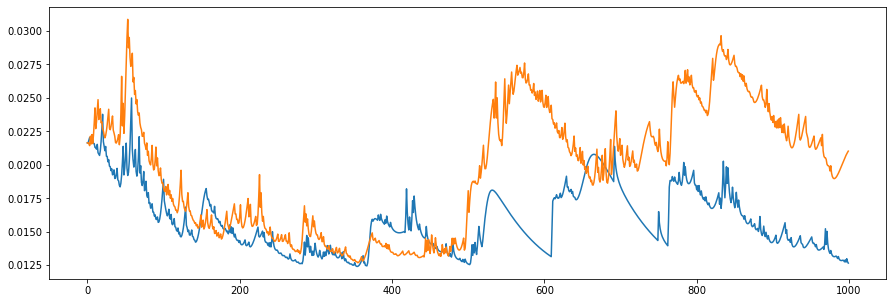

In [9]:
def learning(outcomes, D=10, M=10):
    
    p_jss = np.stack([np.eye(D), (np.ones((D,D)) - np.eye(D))/(D-1)], 0)
    
    likelihoods = np.arange(1/(2*D), 1., 1/D)[:, None, None]
    
    rho = np.arange(1/(2*M), 1, 1/M)
    stay = np.stack([1 - rho, rho], -1)
    change = np.array([1., 0.])[None].repeat(M, -2)
    p_rjj = np.stack([stay, change], -2)
    
    kappa = 1e-3
    p_rr = (1 - kappa) * np.eye(M) + kappa * (np.diag(np.ones(M-1), 1) + np.diag(np.ones(M-1), -1))/2
    p_rr = ops.index_update(p_rr, ops.index[[0, -1], [1, -2]], kappa)
    
    def scan_fn(probs, o):
        pred = np.einsum('jsk,rjl,rq,sjr->klq', p_jss, p_rjj, p_rr, probs)
        ol = likelihoods**o * (1 - likelihoods)**(1 - o)
        post = ol * pred
        
        m = np.sum(probs * likelihoods)
        e = probs[:, -1].sum()
        r = np.sum(probs * rho)
        
        q = post/post.sum()
        return q, (m, e, r, q)
    
    r0 = np.exp(- 1 * np.arange(M)) #np.eye(M)[0]
    probs = np.ones((D, 1, 1))/D * np.array([1., 0])[:, None] * r0/r0.sum()
    _, sequence = lax.scan(scan_fn, probs, outcomes)
        
    return sequence[0], sequence[1], sequence[2], sequence[3]

D = 100
M = 50

m, e, r1, post = learning(obs_swtch, D=D, M=M)

plt.subplots(figsize=(15, 5))
plt.plot(probs_swtch)
plt.plot(m)
plt.plot(e)

m, e, r2, post = learning(obs_drft, D=D, M=M)

plt.subplots(figsize=(15, 5))
plt.plot(probs_drft)
plt.plot(m)
plt.plot(e)

plt.subplots(figsize=(15, 5))
plt.plot(r1)
plt.plot(r2)

Well, so far so good. We can implement the discretised generative model for various dynamic MABs or try to figure out a equally good varaitional inference algo.

Instead of discretizing the reward probability $p$, we can try to learn it using a Beta distribution as a conjugate prior
\begin{equation}
p(o_t,\theta) = p(o_t|\theta)p(\theta)
\end{equation}
where
\begin{equation}
p(o_t|\theta) = \theta_0^{\delta_{o_t,0}}\theta_1^{\delta_{o_t,1}}
\end{equation}
and
\begin{equation}
p(\theta) = \frac{1}{B(\alpha)}\theta_0^{\alpha_0}\theta_1^{\alpha_1}
\end{equation}
so that the reward probability is calculated via the $\alpha$s
\begin{equation}
p(o_t=1) = \frac{\alpha_1}{\alpha_0+\alpha_1}
\end{equation}

Normally, the update would read
\begin{equation}
p(\theta|o_t) = \frac{1}{B(\alpha')}\theta_0^{\alpha'_0}\theta_1^{\alpha'_1}
\end{equation}
where
\begin{equation}
\alpha'_i = \alpha_i + \delta_{o_t,i}
\end{equation}
Here, no old observation is ever forgotten and all equally influence the estimate of the reward probability. Hence, this formulation is unable to track a bandit with changing probability.

One can now introduce a simple change to the update of the $\alpha$
\begin{equation}
\alpha'_i = \lambda\alpha_i + \delta_{o_t,i}
\end{equation}
where $\lambda\in[0,1]$ is a forgetting factor. Here, observations which lie further in the past are more downweighted than recent observations. This is implemented in the following cell. So far, I am unsure how to properly put this into the generative model, maybe as $p(o_t,\theta) = p(o_t|\theta)[p(\theta)]^{\lambda}$?

In the future, it would be interesting to introduce a trial dependent $\lambda_t$ which is adjusted according to the environmental volatility. 

Traced<ShapedArray(int16[]):JaxprTrace(level=0/0)>
Traced<ShapedArray(int16[]):JaxprTrace(level=0/0)>
15.885664 10.926266


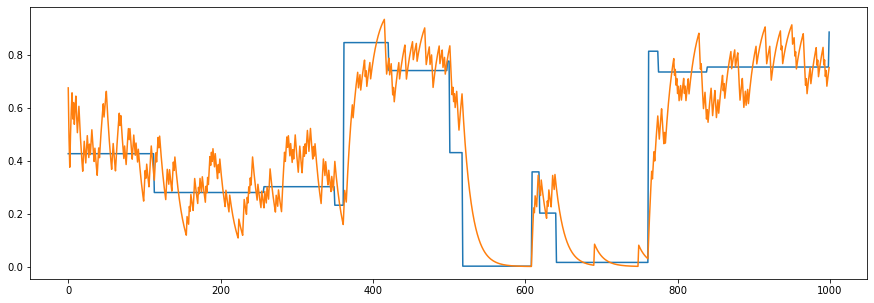

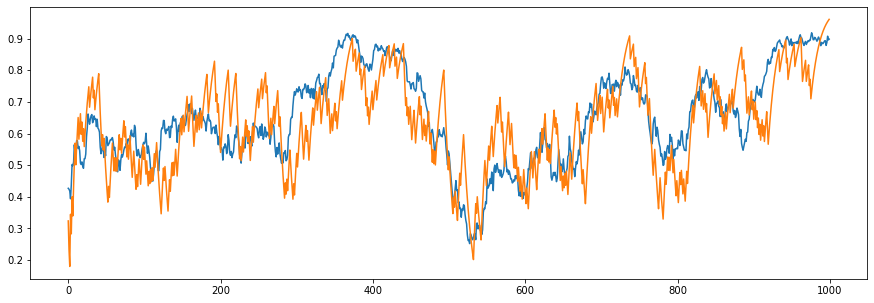

In [13]:
lamb = 0.92

def learning(outcomes):
    
    
    def scan_fn(carry, o):
        post_p, post_alpha = carry
        
        obs = o.astype(np.int16)
        print(obs)
        
        alpha_0 = (1-obs) + lamb * post_alpha[0]
        alpha_1 = obs + lamb * post_alpha[1]
        
        q_alpha = np.array([alpha_0, alpha_1])
        
        q_p = q_alpha
        q_p /= q_p.sum()
        
        return (q_p, q_alpha), {'prob': q_p, 'alpha': q_alpha}

    q_p_init = np.array([0.5,0.5], dtype=np.float32)
    q_alpha_init = np.array([1, 1], dtype=np.float32)
    carry = (q_p_init, q_alpha_init)
    _, sequence = lax.scan(scan_fn, carry, outcomes)
        
    return sequence

sequence = learning(obs_swtch)
q_p = sequence['prob']
q_alpha = sequence['alpha']

plt.subplots(figsize=(15, 5))
plt.plot(probs_swtch)
plt.plot(q_p[:,1])

#plt.subplots(figsize=(15, 5))
#plt.plot(q_alpha[:,1])
#plt.plot(q_alpha[:,0])

err_swtch = np.square(probs_swtch-q_p[:,1]).sum()

sequence = learning(obs_drft)
q_p = sequence['prob']
q_alpha = sequence['alpha']

plt.subplots(figsize=(15, 5))
plt.plot(probs_drft)
plt.plot(q_p[:,1])

err_drft = np.square(probs_drft-q_p[:,1]).sum()

print(err_swtch, err_drft)